# Warming projections from FRIDA

Run the forcing from FRIDA through the calibrated FaIR model and compare FRIDA's warming against this.

In [1]:
import fair
from fair.interface import fill, initialise
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np

/nfs/b0110/Users/mencsm/miniconda3/envs/frida-forcing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fair.__version__

'2.1.0+4.g9c8e917'

In [3]:
fair.__file__

'/nfs/b0110/Users/mencsm/miniconda3/envs/frida-forcing/lib/python3.11/site-packages/fair/__init__.py'

In [4]:
df_frida = pd.read_csv('../data/frida0.1-20230306-warming-forcing.csv', index_col=0)

In [5]:
df_frida.index.name = 'year'

In [6]:
df_frida

,Observed warming,GHG forcing
year,,
1980.000,0.400000,0.968990
1980.125,0.402537,0.965750
1980.250,0.405068,0.962555
1980.375,0.407593,0.959402
1980.500,0.410112,0.956293
...,...,...
2099.500,3.097675,4.500846
2099.625,3.099750,4.501094
2099.750,3.101821,4.501336


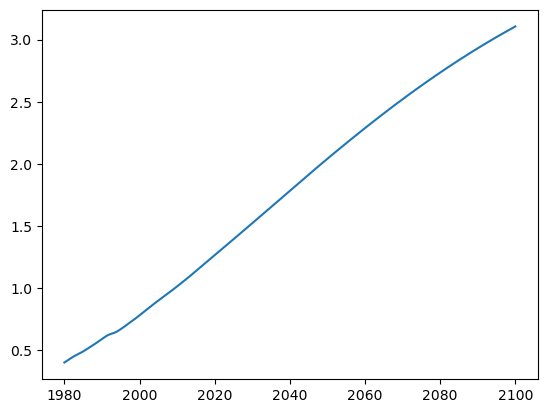

In [7]:
pl.plot(df_frida['Observed warming'])

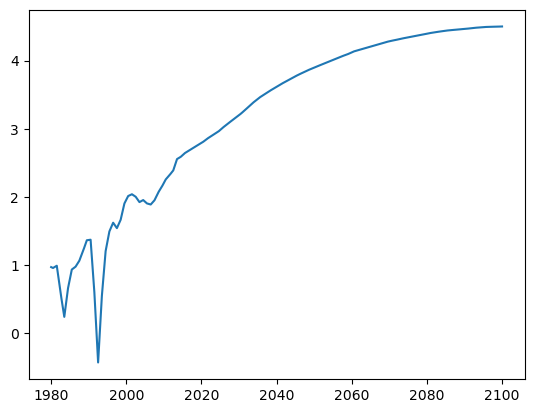

In [8]:
pl.plot(df_frida['GHG forcing'])  # incorrectly named

In [9]:
df_configs = pd.read_csv('../data/calibrated_constrained_parameters_v1.1.0.csv', index_col=0)
df_configs.index.name = 'config'

In [10]:
df_configs

,gamma,c1,c2,c3,kappa1,kappa2,kappa3,epsilon,sigma_eta,sigma_xi,...,scale Stratospheric water vapour,scale Contrails,scale Light absorbing particles on snow and ice,scale Land use,scale Volcanic,solar_amplitude,solar_trend,scale CO2,co2_concentration_1750,seed
config,,,,,,,,,,,,,,,,,,,,,
223,2.542893,4.427776,6.439976,27.811738,1.520582,2.611941,0.791147,1.785763,0.019479,0.224300,...,0.108490,2.909226,1.968794,1.153243,1.174896,1.150642,0.074411,1.113938,280.996949,1444740
248,2.699183,5.652514,12.693147,96.305433,1.451888,2.190332,1.587625,1.503535,0.634219,0.407836,...,1.120879,1.301683,1.608106,1.257000,1.114128,1.235605,-0.043372,1.103832,279.272092,1454715
337,5.560834,4.520785,29.034908,31.431180,1.140293,2.933847,1.202307,1.639030,0.757088,0.525296,...,0.361334,0.788912,0.290387,1.168830,1.044172,0.944002,0.059474,1.168394,280.221119,1490226
1126,9.119766,4.038270,10.507803,136.797996,0.901322,2.853364,1.180568,1.633855,0.842745,0.469932,...,0.092992,1.323717,1.284205,0.765529,1.183536,0.698080,-0.006882,1.027689,276.774836,1805037
1483,1.541741,5.884384,10.171038,144.590161,1.324372,5.830341,0.986666,1.261385,0.493214,0.743539,...,1.774764,1.342722,0.741301,0.816963,0.851670,1.046927,0.011883,0.978011,275.662447,1947480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492261,4.968727,4.218896,9.667449,30.636191,0.736617,8.853330,0.935823,1.880711,0.837531,0.297188,...,1.756522,0.512282,0.191991,1.145589,1.227137,0.972447,-0.063055,1.016986,277.309390,596767902
1495153,1.322185,5.140556,10.609605,71.178776,1.137627,4.253920,2.038106,1.768273,0.511371,0.575900,...,0.546554,0.998386,1.431100,1.550799,0.707496,0.938940,0.010310,0.900180,279.193966,597921810
1496559,12.387113,2.281608,6.387238,158.919994,1.103254,6.109164,1.769013,1.829621,2.027779,0.511290,...,1.061279,1.373184,0.908154,0.827565,1.010113,0.592746,-0.035975,0.963439,276.347510,598482804


In [11]:
f = fair.FAIR()

In [12]:
f.define_time(1980, 2100, 1/8)

In [13]:
f.timebounds

array([1980.   , 1980.125, 1980.25 , 1980.375, 1980.5  , 1980.625,
       1980.75 , 1980.875, 1981.   , 1981.125, 1981.25 , 1981.375,
       1981.5  , 1981.625, 1981.75 , 1981.875, 1982.   , 1982.125,
       1982.25 , 1982.375, 1982.5  , 1982.625, 1982.75 , 1982.875,
       1983.   , 1983.125, 1983.25 , 1983.375, 1983.5  , 1983.625,
       1983.75 , 1983.875, 1984.   , 1984.125, 1984.25 , 1984.375,
       1984.5  , 1984.625, 1984.75 , 1984.875, 1985.   , 1985.125,
       1985.25 , 1985.375, 1985.5  , 1985.625, 1985.75 , 1985.875,
       1986.   , 1986.125, 1986.25 , 1986.375, 1986.5  , 1986.625,
       1986.75 , 1986.875, 1987.   , 1987.125, 1987.25 , 1987.375,
       1987.5  , 1987.625, 1987.75 , 1987.875, 1988.   , 1988.125,
       1988.25 , 1988.375, 1988.5  , 1988.625, 1988.75 , 1988.875,
       1989.   , 1989.125, 1989.25 , 1989.375, 1989.5  , 1989.625,
       1989.75 , 1989.875, 1990.   , 1990.125, 1990.25 , 1990.375,
       1990.5  , 1990.625, 1990.75 , 1990.875, 1991.   , 1991.

In [14]:
f.define_scenarios(['frida'])

In [15]:
df_configs.index

Int64Index([    223,     248,     337,    1126,    1483,    2227,    4608,
               5683,    5797,    8678,
            ...
            1487259, 1487663, 1487726, 1488018, 1491376, 1492261, 1495153,
            1496559, 1497149, 1498501],
           dtype='int64', name='config', length=1001)

In [16]:
f.define_configs(df_configs.index)

In [17]:
# Create an aggregate forcing time series specie.
f.define_species(['Fext'],
    {
        'Fext': {
            'type': 'unspecified',
            'input_mode': 'forcing',
            'greenhouse_gas': False,
            'aerosol_chemistry_from_emissions': False,
            'aerosol_chemistry_from_concentration': False
        }
    }
)

In [18]:
f.allocate()

In [19]:
f.forcing.coords

Coordinates:
  * timebounds  (timebounds) float64 1.98e+03 1.98e+03 ... 2.1e+03 2.1e+03
  * scenario    (scenario) <U5 'frida'
  * config      (config) int64 223 248 337 1126 ... 1496559 1497149 1498501
  * specie      (specie) <U4 'Fext'

In [20]:
f.forcing.shape

(961, 1, 1001, 1)

In [21]:
f.forcing[:, 0, :, 0] = df_frida['GHG forcing'].values[:, None]

In [22]:
# import configs into fair
fill(f.climate_configs["ocean_heat_capacity"], df_configs.loc[:, "c1":"c3"].values)
fill(f.climate_configs["ocean_heat_transfer"], df_configs.loc[:, "kappa1":"kappa3"].values)
fill(f.climate_configs["deep_ocean_efficacy"], df_configs["epsilon"].values.squeeze())
fill(f.climate_configs["gamma_autocorrelation"], df_configs["gamma"].values.squeeze())
fill(f.climate_configs["sigma_eta"], df_configs["sigma_eta"].values.squeeze())
fill(f.climate_configs["sigma_xi"], df_configs["sigma_xi"].values.squeeze())
fill(f.climate_configs["seed"], df_configs["seed"])
fill(f.climate_configs["stochastic_run"], True)
fill(f.climate_configs["use_seed"], True)
fill(f.climate_configs["forcing_4co2"], df_configs["F_4xCO2"])

Note: we have initialised FaIR to be 0.4C in all ocean layers in 1980; effectively assuming the 1980 conditions are equilibrium. This isn't correct as in 1980 we are in a transient regime; the ocean has warmed by a non-zero, but less than equilibrium, amount.

In [23]:
df_fair1980 = pd.read_csv('../output/fair_1980_state.csv', index_col=0)
df_fair1980

,0,1,2
config,,,
223,0.282367,0.234236,0.186335
248,0.197434,0.112889,0.111236
337,0.152669,0.267558,0.278953
1126,0.187971,0.125814,0.083456
1483,0.510628,0.339496,0.067510
...,...,...,...
1492261,0.426868,0.369430,0.302564
1495153,0.349554,0.178557,0.105316
1496559,0.336750,0.151012,0.067935


In [24]:
# initial conditions
initialise(f.forcing, df_frida.loc[1980, 'GHG forcing'])
fill(f.temperature, df_fair1980.values, timebounds=1980, scenario='frida')
#initialise(f.temperature, 0)
#fill(f.temperature, df_frida.loc[1980, 'Observed warming'], layer=0, timebounds=1980)

In [25]:
f.run()

/nfs/b0110/Users/mencsm/miniconda3/envs/frida-forcing/lib/python3.11/site-packages/scipy/stats/_multivariate.py:753: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
Running 1001 projections in parallel: 100%|██| 960/960 [00:00<00:00, 6883.53timesteps/s]


In [26]:
df_ar6 = pd.read_csv('../data/AR6_GMST.csv', index_col=0)
df_ar6

,gmst
year,
1850,-0.058676
1851,0.048824
1852,0.078824
1853,0.046324
1854,0.048824
...,...
2016,1.263824
2017,1.178824
2018,1.101324


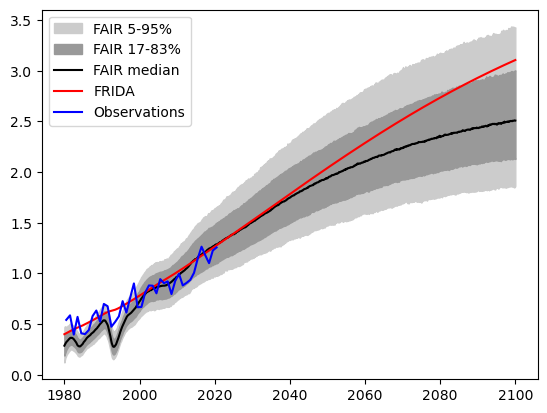

In [27]:
pl.fill_between(
    f.timebounds, 
    np.percentile(f.temperature[:, 0, :, 0], 5, axis=1), 
    np.percentile(f.temperature[:, 0, :, 0], 95, axis=1),
    color='0.8',
    label = 'FAIR 5-95%'
)
pl.fill_between(
    f.timebounds, 
    np.percentile(f.temperature[:, 0, :, 0], 17, axis=1), 
    np.percentile(f.temperature[:, 0, :, 0], 83, axis=1),
    color='0.6',
    label = 'FAIR 17-83%'
)
pl.plot(f.timebounds, np.median(f.temperature[:, 0, :, 0], axis=1), color='k', label='FAIR median')
pl.plot(df_frida['Observed warming'], color='r', label='FRIDA')
pl.plot(df_ar6.index[130:]+0.5, df_ar6.loc[1980:, 'gmst'], color='b', label='Observations')
pl.legend()